Hands-on Code Implementation of the Chapter 06 of 'Build LLM From Scratch'.

In [1]:
#! pip install pandas
#! pip install imblearn

In [1]:
import tiktoken
import torch
import os
import urllib.request
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from importlib.metadata import version
import sys
import numpy as np
import zipfile
from pathlib import Path
import pandas as pd
from imblearn.over_sampling import SMOTE, ADASYN
from torch.utils.data import Dataset, DataLoader
import math
import torch

In [2]:

packages = ["matplotlib","numpy","tiktoken", "tensorflow","torch"]
for pack in packages:
    print(f'Version for {pack} : {version(pack)}')

Version for matplotlib : 3.9.2
Version for numpy : 1.24.3
Version for tiktoken : 0.7.0
Version for tensorflow : 2.13.1
Version for torch : 2.4.0


In [2]:
sys.path.insert(0, 'D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch04\Transformer_Implementation')
sys.path.insert(2, 'D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch05\CustomGPT_Pretraining')
sys.path.insert(2, 'D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch06\CustomGPT_ClassificationFT')

from text_generation import Text_Generation
from gpt2 import GPT2
from gpt_download import download_and_load_gpt2
from load_model_weights import *
from plot_metrics import Plots
from metrics import *
from gpt2_classificationFT import GPT2_ClassificationFineTune

In [3]:
#The lines of code for downloading file is taken as in from the ch06.ipynb file of code repo of "Build LLM From Scratch".
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [6]:
!nvidia-smi

Sun Apr 20 13:56:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              5W /   30W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
spam_data = pd.read_csv(data_file_path, sep='\t', header = None, names=['Label', 'Text'])
spam_data.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
def create_balanced_data(df,target,balancing_algo='naive'):

    '''
    This class assumes a binary classification dataset only.
    '''
    
    if balancing_algo == 'naive':

        #Detect the minority class and the corresponding record count:
        class_count = df[target].value_counts().array.tolist()
        class_name = df[target].value_counts().index
        min_count = min(class_count)
        minority_name = class_name[class_count.index(min_count)]

        #Prepare the minority and majority class dataset:
        min_df = df[df[target] == minority_name]
        max_df = df[df[target] != minority_name].sample(min_count, random_state=123)
        balanced_df = pd.concat([max_df,min_df], ignore_index=True)

    #Check: How to use Adasysn on textual data
    elif balancing_algo == 'adasyn':
        Y = df[target]
        X = df[[col for col in df.columns if col != target]]
        X_resampled, y_resampled = ADASYN().fit_resample(X, Y)
        balanced_df = pd.concat([X_resampled,y_resampled], axis=1)

    return balanced_df

bal_df = create_balanced_data(spam_data,'Label','naive')
bal_df['Label'].value_counts()

Label
ham     747
spam    747
Name: count, dtype: int64

In [6]:
bal_df['Label'] = bal_df['Label'].map({'spam':1, 'ham': 0})
bal_df

,Label,Text
0,0,Awww dat is sweet! We can think of something t...
1,0,Just got to &lt;#&gt;
2,0,"The word ""Checkmate"" in chess comes from the P..."
3,0,This is wishing you a great day. Moji told me ...
4,0,Thank you. do you generally date the brothas?
...,...,...
1489,1,Want explicit SEX in 30 secs? Ring 02073162414...
1490,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
1491,1,Had your contract mobile 11 Mnths? Latest Moto...
1492,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [7]:
def dataset_split(df, train_split, val_split):

    #Shuffle the dataset:
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    #Create the split indices:
    row_count = df.shape[0]
    train_df = df[ : int(train_split * row_count)]
    val_df = df[int(train_split * row_count) : int(train_split * row_count) + int(val_split * row_count)]
    test_df = df[int(train_split * row_count) + int(val_split * row_count) : ]

    print('Train and Val Split Index :: ',int(train_split * row_count), int(train_split * row_count) + int(val_split * row_count))
    return train_df, val_df, test_df

train_df, val_df, test_df = dataset_split(bal_df, 0.7, 0.1)

print('Train Data: ', train_df.shape)
print('Val Data: ', val_df.shape)
print('Test Data: ', test_df.shape)

Train and Val Split Index ::  1045 1194
Train Data:  (1045, 2)
Val Data:  (149, 2)
Test Data:  (300, 2)


In [11]:
#Save the train, validation and test data:
train_df.to_csv("spam_train.csv", index=None)
val_df.to_csv("spam_validation.csv", index=None)
test_df.to_csv("spam_test.csv", index=None)

In [8]:
tokenizer = tiktoken.get_encoding('gpt2')
last_token_id = tokenizer.encode('<|endoftext|>', allowed_special='all')[0]

In [9]:
class GPTCustomSFTDataset(Dataset):
    
    def __init__(self, text,tokenizer, last_token_id = None, max_seq_length = None):
        super().__init__()

        #Read the data:
        self.data = pd.read_csv(text)

        #Get the encoded data:
        self.encoded_data = [tokenizer.encode(row, allowed_special='all') 
                             for row in self.data['Text'] 
                            ]
        
        #Truncate the text according to the max sequence length given in the input:
        if max_seq_length is not None:
            self.max_length = max_seq_length

            #Truncate all sequences to the max length:
            self.encoded_data = [row[:self.max_length] 
                                for row in self.encoded_data]
        
        else:
            self.max_length = self._max_length()
            
        #Pad the texts to the maximum length if the length of the sequence is less that the maximum length, else use the sequence as is:
        #Final form of the data that will be used for training
        self.encoded_data = [
                            row + [last_token_id] * (self.max_length - len(row)) 
                            for row in self.encoded_data
                            ]
        

    def __getitem__(self, index):
        X = self.encoded_data[index]
        Y = self.data.iloc[index]['Label']

        X_tensor = torch.tensor(X,dtype=torch.long)
        Y_tensor = torch.tensor(Y,dtype=torch.long)

        #Return the X and Y Tensors for the dataloader
        return X_tensor, Y_tensor

    def __len__(self):
        return len(self.data)
    
    def _max_length(self):
        max_length = max([len(row) for row in self.encoded_data])
        return max_length

In [10]:
#Create the custom dataloader function that will call the GPTCustomSFTDataset class to create the dataset from the given text:
def GPTCustomSFTDataloader(file_path,last_token_id = None, max_seq_length = None, batch_size=8,
                        shuffle=True, drop_last=True,num_workers=0):

    #Initializer the tokenizer
    tokenizer = tiktoken.get_encoding('gpt2')

    #Get the last token id of the tokenizer selected:
    if last_token_id is None:
        last_token_id = tokenizer.encode('<|endoftext|>', allowed_special='all')[0]

    #Create the dataset with the tokenizer and the input file:
    dataset = GPTCustomSFTDataset(text = file_path, tokenizer=tokenizer, last_token_id = last_token_id, max_seq_length= max_seq_length)

    #Create the dataloader with the dataset
    custom_dataloader = DataLoader(dataset,batch_size=batch_size,
                                   shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)


    return custom_dataloader

In [11]:
train_dataloader = GPTCustomSFTDataloader("spam_train.csv")
print('Number of training batches :: ', len(train_dataloader))

print('Train Loader')
for input_batch, target_batch in train_dataloader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

train_max_length = input_batch.shape[1]

print('-----------------------------------')

val_dataloader = GPTCustomSFTDataloader("spam_validation.csv", max_seq_length= train_max_length)
print('Number of validation batches :: ', len(val_dataloader))

print('Validation Loader')
for input_batch, target_batch in val_dataloader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

print('-----------------------------------')

test_dataloader = GPTCustomSFTDataloader("spam_test.csv", max_seq_length= train_max_length)
print('Number of test batches :: ', len(test_dataloader))

print('Test Loader')
for input_batch, target_batch in test_dataloader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)


Number of training batches ::  130
Train Loader
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
-----------------------------------
Number of validation batches ::  18
Validation Loader
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
-----------------------------------
Number of test batches ::  37
Test Loader
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [12]:
# Load the model config:
def load_model_config(base_config,model_name,config_dict):

    updated_config = base_config.copy()
    updated_config.update(config_dict[model_name])
    updated_config.update({'qkv_bias':True, 'context_length':1024})

    return updated_config

# Base configs:
GPT2_CONFIG = {
    'vocab_size':50257,
    'embedding_dimension':768,
    'num_heads':12,
    'context_length':256, #We used a smaller context length till now to do quick training of the model to make sure the code is working properly.
    'dropout':0.1,
    'qkv_bias':False,
    'num_layers':12,
    }

gpt2_config_dict = {
    "gpt2_124M" : {'embedding_dimension':768, 'num_heads':12, 'num_layers':12},
    "gpt2_355M" : {'embedding_dimension':1024, 'num_heads':16, 'num_layers':24},
    "gpt2_774M" : {'embedding_dimension':1280, 'num_heads':20, 'num_layers':36},
    "gpt2_1558M" : {'embedding_dimension':1600, 'num_heads':25, 'num_layers':48},
}

model_name = "gpt2_124M"

updatedGPT2_CONFIG = load_model_config(GPT2_CONFIG,model_name,gpt2_config_dict)

assert train_max_length <= updatedGPT2_CONFIG['context_length']

gpt2_preTrained = GPT2(updatedGPT2_CONFIG)
gpt2_preTrained.eval()

GPT2(
  (token_embedding): Embedding(50257, 768)
  (pos_embedding): Embedding(1024, 768)
  (token_dropout): Dropout(p=0.1, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (attention_block): MultiHead_Attention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_projection): Linear(in_features=768, out_features=768, bias=True)
      )
      (feedForward): FeedForwardBlock(
        (block): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm_attention): LayerNormalization()
      (layer_norm_feedforward): LayerNormalization()
      (dropout): Dropout(p=0.1, inplace=False)
    )
 

In [13]:
#Get the OpenAI's parameters and settings loaded:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [14]:
#Load the weights from OpenAI GPT2 to our instance:
gpt2_loadedWeights(gpt2_preTrained, params)
gpt2_preTrained.eval();

In [17]:
#TO DO: Replace the following with the modular code and the class designed for text generation: 
# Next Cell contains the modular code for text generation:

from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)

text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=gpt2_preTrained,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=updatedGPT2_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=gpt2_preTrained,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=updatedGPT2_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work
Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [ ]:
#Modular code using Class Text_Generation to generate the outputs:

input_text = "Every effort moves you"
generate = Text_Generation(model=gpt2_preTrained, device='cpu', tokenizer_model='gpt2')
output_text = generate.text_generation(input_text = input_text, max_new_tokens=15, temp=0.0,top_k= None, eos_id=50256)
print(output_text)
print('-------------')
input_text =  (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
output_text = generate.text_generation(input_text = input_text, max_new_tokens=15, temp=0.0,top_k= None, eos_id=50256)
print(output_text)


Every effort moves you forward.The first step is to understand the importance of your work
-------------
Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'The following text 'spam'? Answer with 'yes' or


In [15]:
#Freeze the model weights first:
torch.manual_seed(123)
for params in gpt2_preTrained.parameters():
    params.requires_grad = False

#Add the classification layer:
num_classes = 2
gpt2_preTrained.final_projection = torch.nn.Linear(in_features=updatedGPT2_CONFIG['embedding_dimension'], out_features= num_classes)

#Unfreeze the final layer normalization block parameters for fine-tuning:
for params in gpt2_preTrained.final_layerNorm.parameters():
    params.requires_grad = True

#Unfreeze the last transformer block parameters for fine-tuning:
for params in gpt2_preTrained.transformer_block[-1].parameters():
    params.requires_grad = True


#Checking if the model output tensor:
input_text = "Do you have time"
input_encoded = tokenizer.encode(input_text,allowed_special='all')
input_encoded = torch.tensor(input_encoded).unsqueeze(0)

print('Input Dimension : ', input_encoded.shape)
print('Inputs: ', input_encoded)


with torch.no_grad():
    output_tensor = gpt2_preTrained(input_encoded) #Need to convert the encoded token list to torch tensor and add the batch dimension through unsqueeze
print('Output Tensor:: \n', output_tensor)
print('Output Dimension:: ', output_tensor.shape)


Input Dimension :  torch.Size([1, 4])
Inputs:  tensor([[5211,  345,  423,  640]])
Output Tensor:: 
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Output Dimension::  torch.Size([1, 4, 2])


##### In order to load the previously trained supervised fine-tuned model, run till the above code and then go to the last cell. Run that cell and the supervised fine-tuned weights will be loaded into the "gpt2_preTrained" instance.

##### In order to do the supervised fine-tuning for the first time, run all the below cells (In order).

In [16]:
def accuracy_loader(dataloader, model, device, num_batches = None):

    correct_pred, num_samples = 0, 0
    model.eval()

    if num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))
    
    for i, (X_batch, Y_batch) in enumerate(dataloader):

        if i < num_batches:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            with torch.no_grad():
                output_logits = model(X_batch)
            
            last_idx_logits = output_logits[:, -1, :]
            predictions = torch.argmax(last_idx_logits, dim=-1)

            num_samples += predictions.shape[0]

            correct_pred += (predictions == Y_batch).sum().item()

        else:
            break
    avg_accuracy = correct_pred / num_samples
    return avg_accuracy

In [17]:
def classification_loss_batch(input_batch, target_batch, model, device ):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    output_logits = model(input_batch)
    last_idx_logits = output_logits[:, -1, :]
    classify_loss = torch.nn.functional.cross_entropy(last_idx_logits, target_batch)
    return classify_loss

In [18]:
#Same function as used in Ch 05. TO be replaced by the class designed to calculate loss across different training sytles once the modular code is ready!
def loss_loader(model, device, dataloader, num_batches = None ):
    
    batch_loss = 0.0
    if len(dataloader) == 0:
        print('No batches/data in the dataloader..!')
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches,len(dataloader))
        
    for i, (input_batch, target_batch) in enumerate(dataloader):

        if i < num_batches:
            ce_loss = classification_loss_batch(input_batch, target_batch, model, device)
            batch_loss += ce_loss.item()
        else:
            break

    avg_batch_loss = batch_loss / num_batches
    return avg_batch_loss

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)

gpt2_preTrained.to(device)

torch.manual_seed(123)

train_accuracy = accuracy_loader(train_dataloader, gpt2_preTrained, device, num_batches=10)
val_accuracy = accuracy_loader(val_dataloader, gpt2_preTrained, device, num_batches=10)
test_accuracy = accuracy_loader(test_dataloader, gpt2_preTrained, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = loss_loader( gpt2_preTrained, device,train_dataloader, num_batches=5)
    val_loss = loss_loader( gpt2_preTrained, device, val_dataloader, num_batches=5)
    test_loss = loss_loader( gpt2_preTrained, device, test_dataloader, num_batches=5)
    
print('----------------------------------')
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Device Available:  cuda
Training accuracy: 0.00%
Validation accuracy: 0.00%
Test accuracy: 0.00%
----------------------------------
Training loss: 8.855
Validation loss: 7.894
Test loss: 8.018


In [20]:
#Same function as used in Ch 05. TO be replaced by the class designed to calculate loss across different training sytles once the modular code is ready!
def evaluate_model(model, device, train_dataLoader, test_dataLoader, num_batches=None):

    model.eval()

    with torch.no_grad():
        train_loss = loss_loader(model, device, train_dataLoader, num_batches)
        test_loss = loss_loader(model, device, test_dataLoader, num_batches)

    model.train()

    return train_loss, test_loss

In [ ]:
def train_classifier_model(model, optimizer, train_dataLoader, test_dataLoader, device, 
                num_epochs, eval_batchSize, eval_freq):
    
    train_losses, test_losses, train_accuracy, val_accuracy = [], [], [], []

    num_samples, global_step = 0, -1

    for ep in range(num_epochs):

        model.train()

        for train_x, train_y in train_dataLoader:

            optimizer.zero_grad()
            loss = classification_loss_batch(train_x, train_y, model, device)
            loss.backward()
            optimizer.step()
            global_step += 1
            num_samples += train_x.shape[0]

            if global_step % eval_freq == 0:

                train_loss, test_loss = evaluate_model(model, device, train_dataLoader, test_dataLoader, eval_batchSize)
                train_losses.append(train_loss)
                test_losses.append(test_loss)
                print(f'Epoch No: {ep+1}, Step: {global_step:06d}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')
                
        #Calculate avergae accuracy for each epoch:
        train_accu = accuracy_loader(train_dataloader, gpt2_preTrained, device, num_batches=10)
        val_accu = accuracy_loader(val_dataloader, gpt2_preTrained, device, num_batches=10)
        print(f"Training accuracy: {train_accu*100:.2f}%")
        print(f"Validation accuracy: {val_accu*100:.2f}%")

        train_accuracy.append(train_accu)
        val_accuracy.append(val_accu)
        
    return train_losses, test_losses, train_accuracy, val_accuracy, num_samples

In [ ]:
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)

torch.manual_seed(123)
optimizer = torch.optim.AdamW(gpt2_preTrained.parameters(), lr=5e-5, weight_decay=0.1)

epochs = 5
train_losses, test_losses, train_accuracy, val_accuracy, num_samples = train_classifier_model(model = gpt2_preTrained, optimizer = optimizer, 
                                        train_dataLoader = train_dataloader, test_dataLoader = val_dataloader, 
                                        device = device, num_epochs = epochs, 
                                        eval_batchSize = 5, eval_freq = 50)

end_time = time.time()
train_time =(end_time - start_time) / 60
print(f'-------------- Total Training Time : {train_time:.2f} minutes --------------')

Device Available:  cuda
Epoch No: 1, Step: 000000, Train Loss: 3.530, Test Loss: 3.818


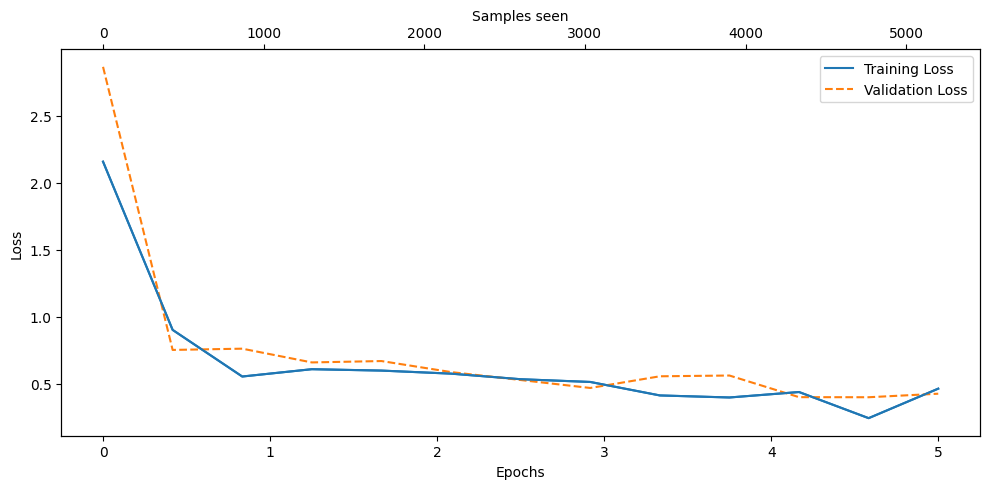

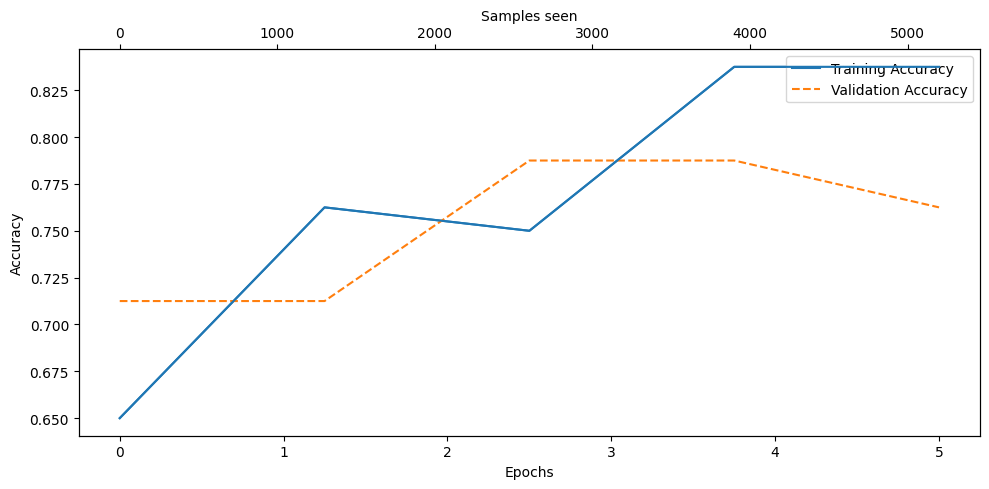

In [ ]:
def plot_metrics(num_samples, epochs, train_values, val_values, label = 'loss'):
    fig, ax = plt.subplots(figsize=(10,5))

    #Epochs vs Loss
    ax.plot(epochs,train_values,label = f'Training {label}')
    ax.plot(epochs, val_values, linestyle="--", label = f'Validation {label}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(f'{label}')
    ax.legend(loc="upper right")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    #Token vs Loss
    ax2 = ax.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(num_samples, train_values)
    ax2.set_xlabel("Samples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}_samples_epochs_SFT.pdf")
    plt.show()

x = torch.linspace(0, epochs, len(train_losses))
samples = torch.linspace(0, num_samples, len(train_losses))
plot_metrics(samples, x, train_losses, test_losses, label = 'Loss')

x = torch.linspace(0, epochs, len(train_accuracy))
samples = torch.linspace(0, num_samples, len(train_accuracy))
plot_metrics(samples, x,train_accuracy, val_accuracy, label = 'Accuracy')

In [ ]:
print("AFTER FINE_TUNING FOR 5 EPOCHS :::::::::\n")
train_accuracy = accuracy_loader(train_dataloader, gpt2_preTrained, device, num_batches=10)
val_accuracy = accuracy_loader(val_dataloader, gpt2_preTrained, device, num_batches=10)
test_accuracy = accuracy_loader(test_dataloader, gpt2_preTrained, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = loss_loader( gpt2_preTrained, device,train_dataloader, num_batches=5)
    val_loss = loss_loader( gpt2_preTrained, device, val_dataloader, num_batches=5)
    test_loss = loss_loader( gpt2_preTrained, device, test_dataloader, num_batches=5)
    
print('----------------------------------')
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

AFTER FINE_TUNING FOR 5 EPOCHS :::::::::

Training accuracy: 75.00%
Validation accuracy: 76.25%
Test accuracy: 82.50%
----------------------------------
Training loss: 0.269
Validation loss: 0.424
Test loss: 0.354


In [27]:
def classify_text(input_text, tokenizer, model, device, max_length,pad_token_id=50256):

    model.eval()

    input_encoded = tokenizer.encode(input_text, allowed_special='all')
    model_context_length = model.pos_embedding.weight.shape[0]

    input_encoded = input_encoded[:min(model_context_length, max_length)]
    input_encoded += [pad_token_id] * (max_length - len(input_encoded))

    input_tensor = torch.tensor(input_encoded,dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        output_logit = model(input_tensor)[:, -1, :]

    class_prediction = torch.argmax(output_logit, dim = -1).item()

    return 'spam' if class_prediction == 1 else 'ham'

In [ ]:
#Test Examples:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_text(
    text_1, tokenizer, gpt2_preTrained, device, max_length=train_max_length
))

print('--------------------')

text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_text(
    text_2, tokenizer, gpt2_preTrained, device, max_length=train_max_length
))

print('--------------------')

text_3 = (
    "Namrata Thakur coded this repository"
)

print(classify_text(
    text_3, tokenizer, gpt2_preTrained, device, max_length=train_max_length
))

spam
--------------------
ham
--------------------
ham


In [28]:
test_df = pd.read_csv('spam_test.csv')
print(test_df.shape)
test_df.head()

(300, 2)


,Label,Text
0,1,85233 FREE>Ringtone!Reply REAL
1,1,Ur cash-balance is currently 500 pounds - to m...
2,1,"Thanks for your ringtone order, reference numb..."
3,0,We live in the next &lt;#&gt; mins
4,1,1st wk FREE! Gr8 tones str8 2 u each wk. Txt N...


In [ ]:
pred_label_list = []
for text in test_df['Text'].values:
    pred_label = classify_text(text, tokenizer, gpt2_preTrained, device, max_length=train_max_length)
    pred_label_list.append(pred_label)

test_df['Pred_Label'] = pred_label_list
test_df.head()

,Label,Text,Pred_Label
0,1,85233 FREE>Ringtone!Reply REAL,ham
1,1,Ur cash-balance is currently 500 pounds - to m...,spam
2,1,"Thanks for your ringtone order, reference numb...",spam
3,0,We live in the next &lt;#&gt; mins,ham
4,1,1st wk FREE! Gr8 tones str8 2 u each wk. Txt N...,spam


In [ ]:
test_df.to_csv('Test_Data_Prediction_Label.csv', index=None)

In [ ]:
#Save the SFT Model:
torch.save(gpt2_preTrained.state_dict(), "gpt2_SFT_Spam.pth")

In [16]:
#Load the model:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)

gpt2_state_dict = torch.load("gpt2_SFT_Spam.pth", map_location=device, weights_only=True)
gpt2_preTrained.load_state_dict(gpt2_state_dict)

Device Available:  cuda


<All keys matched successfully>

##### LORA Implementation to fine-tune the above model using less parameters:

In [17]:
class LORA(torch.nn.Module):
    def __init__(self, feature_in, feature_out, rank, alpha):
        super().__init__()
        
        self.A = torch.nn.Parameter(torch.empty(feature_in, rank))
        #Distribution that A matrix will follow:
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))

        #torch.nn.init.normal_(self.lora_A, mean=0, std=1)

        self.B = torch.nn.Parameter(torch.zeros(rank, feature_out))
        self.alpha = alpha

    def forward(self, input):

        input = self.alpha * (input @ self.A @ self.B)

        return input

In [18]:
class LinearWithLORA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        #features_in, features_out = linear.weight.shape
        self.LORA = LORA(feature_in=linear.in_features, feature_out=linear.out_features, 
                         rank= rank, alpha=alpha)

    def forward(self, input):

        return self.linear(input) + self.LORA(input)

In [19]:
def lora_parameterization(model, rank = 16, alpha = 16):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            setattr(model, name, LinearWithLORA(module, rank, alpha))
        else:
            lora_parameterization(module, rank = 16, alpha = 16)

In [20]:
def freeze_model(model):
    params_orig = sum(p.numel() for p in model.parameters() if p.requires_grad)

    for p in model.parameters():
        p.requires_grad = False
    
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Total trainable parameters after model freeze : ', params)

    return params_orig

In [21]:
params_orig = freeze_model(gpt2_preTrained)
lora_parameterization(gpt2_preTrained, rank = 16, alpha = 16)

params_with_lora = sum(p.numel() for p in gpt2_preTrained.parameters() if p.requires_grad)

print('Total trainable paramters in the original model: ', params_orig)
print('Total parameters in the model after LORA addition: ', params_orig + params_with_lora)
print('Total trainable parameters with LORA (%): ', round((params_with_lora / params_orig)*100, 2))

Total trainable parameters after model freeze :  0
Total trainable paramters in the original model:  7090946
Total parameters in the model after LORA addition:  9757474
Total trainable parameters with LORA (%):  37.6


In [22]:
gpt2_preTrained.to(device)

print(gpt2_preTrained)

GPT2(
  (token_embedding): Embedding(50257, 768)
  (pos_embedding): Embedding(1024, 768)
  (token_dropout): Dropout(p=0.1, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (attention_block): MultiHead_Attention(
        (W_query): LinearWithLORA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (LORA): LORA()
        )
        (W_key): LinearWithLORA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (LORA): LORA()
        )
        (W_value): LinearWithLORA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (LORA): LORA()
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (out_projection): LinearWithLORA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (LORA): LORA()
        )
      )
      (feedForward): FeedForwardBlock(
        (block): Sequential(
          (0): LinearWithLORA(
            (linear):

In [ ]:
metrics = Metrics(gpt2_preTrained, device)

torch.manual_seed(123)
train_accuracy = metrics.accuracy_loader(train_dataloader, num_batches=10)
val_accuracy = metrics.accuracy_loader(val_dataloader, num_batches=10)
test_accuracy = metrics.accuracy_loader(test_dataloader, num_batches=10)

print('Supervised Fine-Tuned Model (without lora) :')
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 85.00%
Validation accuracy: 77.50%
Test accuracy: 78.75%


In [23]:
start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt2_preTrained.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5

gpt2_trainer = GPT2_ClassificationFineTune(model=gpt2_preTrained, 
                            optimizer=optimizer,
                            train_dataLoader=train_dataloader,
                            test_dataLoader=test_dataloader,
                            num_epochs=num_epochs,
                            eval_batchSize=5, 
                            eval_freq=50,
                            device=device)

train_losses, test_losses, train_accuracy, val_accuracy, num_samples = gpt2_trainer.train()

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch No: 1, Step: 000000, Train Loss: 8.435, Test Loss: 6.764
Epoch No: 1, Step: 000050, Train Loss: 0.155, Test Loss: 0.214
Epoch No: 1, Step: 000100, Train Loss: 0.109, Test Loss: 0.230
Training accuracy: 88.37%
Validation accuracy: 89.19%
Epoch No: 2, Step: 000150, Train Loss: 0.138, Test Loss: 0.103
Epoch No: 2, Step: 000200, Train Loss: 0.143, Test Loss: 0.126
Epoch No: 2, Step: 000250, Train Loss: 0.094, Test Loss: 0.018
Training accuracy: 96.06%
Validation accuracy: 96.28%
Epoch No: 3, Step: 000300, Train Loss: 0.163, Test Loss: 0.145
Epoch No: 3, Step: 000350, Train Loss: 0.205, Test Loss: 0.110
Training accuracy: 97.60%
Validation accuracy: 97.64%
Epoch No: 4, Step: 000400, Train Loss: 0.176, Test Loss: 0.128
Epoch No: 4, Step: 000450, Train Loss: 0.080, Test Loss: 0.045
Epoch No: 4, Step: 000500, Train Loss: 0.017, Test Loss: 0.089
Training accuracy: 97.98%
Validation accuracy: 96.28%
Epoch No: 5, Step: 000550, Train Loss: 0.092, Test Loss: 0.012
Epoch No: 5, Step: 000600, T

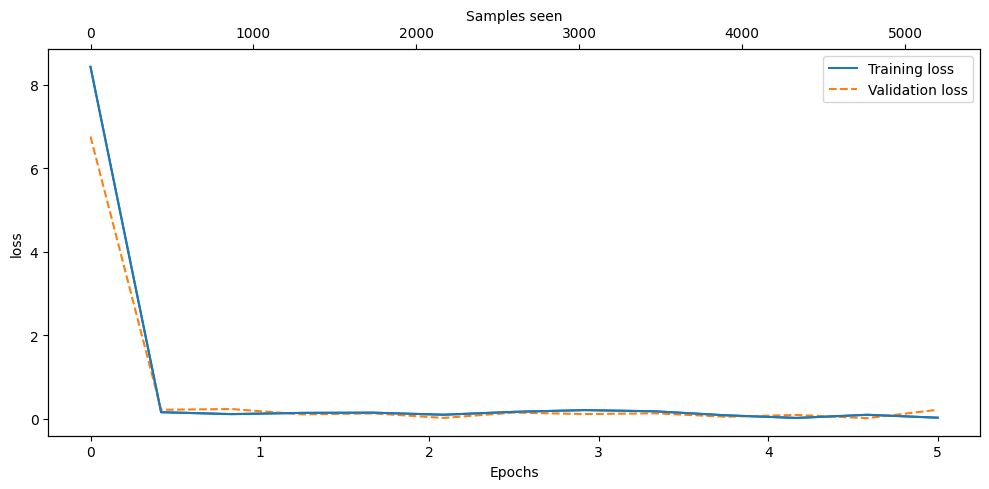

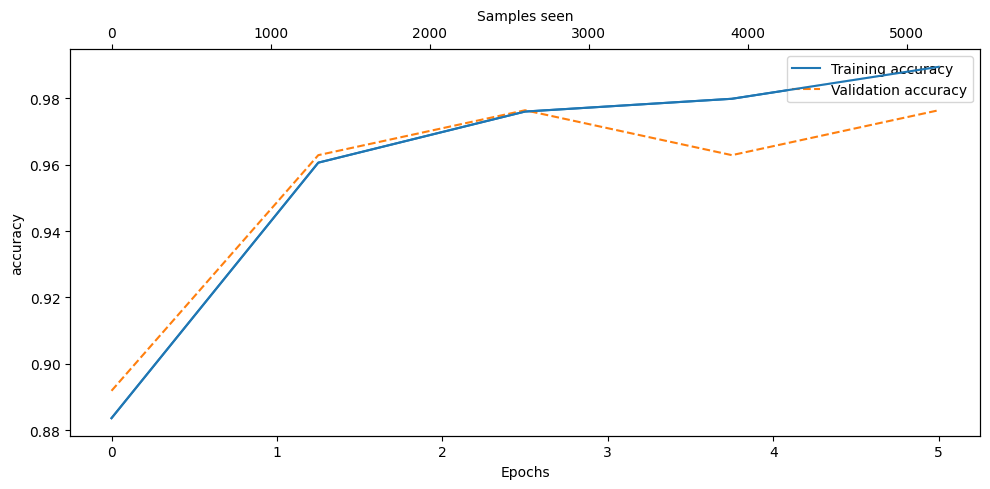

In [25]:
x = torch.linspace(0, num_epochs, len(train_losses))
samples = torch.linspace(0, num_samples, len(train_losses))
plt = Plots(samples, x, train_losses, test_losses, label = 'Loss')
plt.plots('loss', 'SFT_FineTune_LORA')

x = torch.linspace(0, num_epochs, len(train_accuracy))
samples = torch.linspace(0, num_samples, len(train_accuracy))
plt = Plots(samples, x,train_accuracy, val_accuracy, label = 'Accuracy')
plt.plots('accuracy', 'SFT_FineTune_LORA')

In [26]:
metrics = Metrics(gpt2_preTrained, device)

torch.manual_seed(123)
train_accuracy = metrics.accuracy_loader(train_dataloader, num_batches=10)
val_accuracy = metrics.accuracy_loader(val_dataloader, num_batches=10)
test_accuracy = metrics.accuracy_loader(test_dataloader, num_batches=10)

print('Supervised Fine-Tuned Model (With lora) for 5 more epochs:')
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Supervised Fine-Tuned Model (With lora) for 5 more epochs:
Training accuracy: 98.75%
Validation accuracy: 100.00%
Test accuracy: 96.25%


In [29]:
pred_label_list = []
for text in test_df['Text'].values:
    pred_label = classify_text(text, tokenizer, gpt2_preTrained, device, max_length=train_max_length)
    pred_label_list.append(pred_label)

test_df['Pred_Label'] = pred_label_list
test_df.head()

,Label,Text,Pred_Label
0,1,85233 FREE>Ringtone!Reply REAL,spam
1,1,Ur cash-balance is currently 500 pounds - to m...,spam
2,1,"Thanks for your ringtone order, reference numb...",spam
3,0,We live in the next &lt;#&gt; mins,ham
4,1,1st wk FREE! Gr8 tones str8 2 u each wk. Txt N...,spam


In [30]:
test_df.to_csv('Test_Data_Prediction_Label_LORA.csv', index=None)

In [31]:
#Save the LORA-TUNED SFT Model:
torch.save(gpt2_preTrained.state_dict(), "gpt2_SFT_Spam_Lora.pth")

#TO DO: WRITE a summary 